In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


datapath = './ecoli.data'

data = pd.read_csv(datapath, delim_whitespace=True, header=None)

data.columns = ['Sequence Name', 'mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2', 'class'] #adding column names 

data.head(10)

/var/folders/v0/_l0_v32n1f54t6h877vsg9wr0000gn/T/ipykernel_18619/3709306028.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(datapath, delim_whitespace=True, header=None)


,Sequence Name,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp
5,ALKH_ECOLI,0.67,0.39,0.48,0.5,0.36,0.38,0.46,cp
6,AMPD_ECOLI,0.29,0.28,0.48,0.5,0.44,0.23,0.34,cp
7,AMY2_ECOLI,0.21,0.34,0.48,0.5,0.51,0.28,0.39,cp
8,APT_ECOLI,0.20,0.44,0.48,0.5,0.46,0.51,0.57,cp
9,ARAC_ECOLI,0.42,0.40,0.48,0.5,0.56,0.18,0.30,cp


## Clustering Problem Using K-Means++ 


### Lets analyze the data and look for any anomalies

In [2]:
data.info() #looks consistent

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sequence Name  336 non-null    object 
 1   mcg            336 non-null    float64
 2   gvh            336 non-null    float64
 3   lip            336 non-null    float64
 4   chg            336 non-null    float64
 5   aac            336 non-null    float64
 6   alm1           336 non-null    float64
 7   alm2           336 non-null    float64
 8   class          336 non-null    object 
dtypes: float64(7), object(2)
memory usage: 23.8+ KB


In [3]:
data.describe()


,mcg,gvh,lip,chg,aac,alm1,alm2
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,0.500060,0.500000,0.495476,0.501488,0.500030,0.500179,0.499732
std,0.194634,0.148157,0.088495,0.027277,0.122376,0.215751,0.209411
min,0.000000,0.160000,0.480000,0.500000,0.000000,0.030000,0.000000
25%,0.340000,0.400000,0.480000,0.500000,0.420000,0.330000,0.350000
50%,0.500000,0.470000,0.480000,0.500000,0.495000,0.455000,0.430000
75%,0.662500,0.570000,0.480000,0.500000,0.570000,0.710000,0.710000
max,0.890000,1.000000,1.000000,1.000000,0.880000,1.000000,0.990000


In [41]:
scaler = StandardScaler()
features = data.iloc[:, 1:-1]  # selecting all columns except the first (Sequence Name) and last (class)
features_scaled = scaler.fit_transform(features) # sklearn outputs a numpy array after scaling, s convert scaled features back to DataFrame to keep column names
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

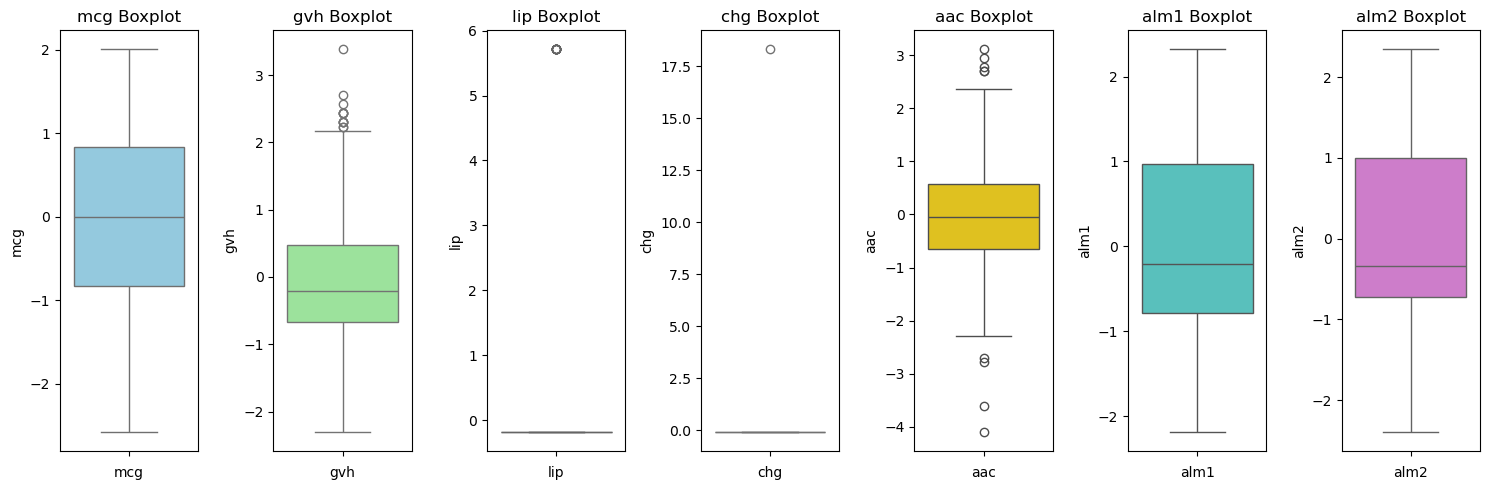

In [52]:
plt.figure(figsize=(15, 5)) #boxplots for each attribute

plt.subplot(1, 7, 1)
sns.boxplot(data=features_scaled_df['mcg'], color='skyblue')
plt.title('mcg Boxplot')
plt.xlabel('mcg')

plt.subplot(1, 7, 2)
sns.boxplot(data=features_scaled_df['gvh'], color='lightgreen')
plt.title('gvh Boxplot')
plt.xlabel('gvh')

plt.subplot(1, 7, 3)
sns.boxplot(data=features_scaled_df['lip'], color='coral')
plt.title('lip Boxplot')
plt.xlabel('lip')

plt.subplot(1, 7, 4)
sns.boxplot(data=features_scaled_df['chg'], color='plum')
plt.title('chg Boxplot')
plt.xlabel('chg')

plt.subplot(1, 7, 5)
sns.boxplot(data=features_scaled_df['aac'], color='gold')
plt.title('aac Boxplot')
plt.xlabel('aac')

plt.subplot(1, 7, 6)
sns.boxplot(data=features_scaled_df['alm1'], color='mediumturquoise')
plt.title('alm1 Boxplot')
plt.xlabel('alm1')

plt.subplot(1, 7, 7)
sns.boxplot(data=features_scaled_df['alm2'], color='orchid')
plt.title('alm2 Boxplot')
plt.xlabel('alm2')

plt.tight_layout()
plt.show()

In [53]:
features_scaled_df['chg'].value_counts() #lip and chg are binary attributes

chg
-0.054636     335
 18.303005      1
Name: count, dtype: int64

In [54]:
features_scaled_df['lip'].value_counts()

lip
-0.175142    326
 5.709641     10
Name: count, dtype: int64

Both features (chg and lip) are binary and highly imbalanced.
Because they don't provide meaningful discrimination between clusters, I will drop them.

In [55]:
cleaned_features = features_scaled_df.drop(columns=['chg', 'lip'])
cleaned_features.columns


Index(['mcg', 'gvh', 'aac', 'alm1', 'alm2'], dtype='object')

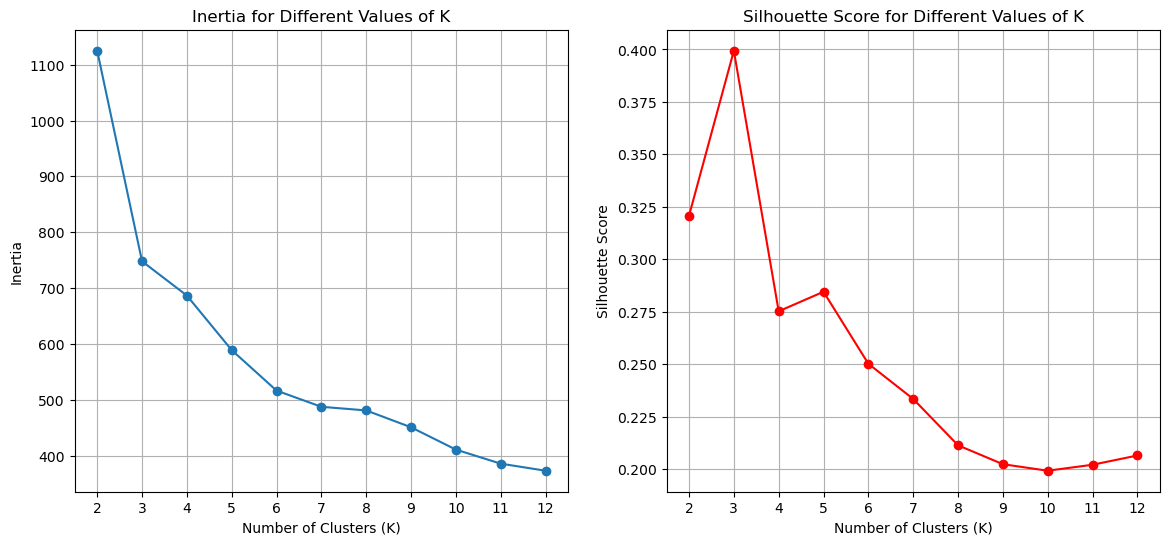

In [56]:
max_k = 12
inertia = []
silhouette_scores = []
k_values = range(2, max_k + 1)

for k in k_values:
    kmeans = KMeans(init='k-means++', n_clusters=k, random_state=42, max_iter=1000)
    cluster_labels = kmeans.fit_predict(cleaned_features)
    inertia.append(kmeans.inertia_)
    sil_score = silhouette_score(cleaned_features, cluster_labels)
    silhouette_scores.append(sil_score)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('Inertia for Different Values of K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='red')
plt.title('Silhouette Score for Different Values of K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

Both the elbow method and silhouette score suggest that k=3 is the optimal number of clusters.

In [57]:
kmeans = KMeans(init='k-means++', n_clusters=3, random_state=42, max_iter=1000)
cluster_labels = kmeans.fit_predict(cleaned_features)

cluster_labels

array([0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1, 1,
       2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,

In [58]:
cleaned_features['Cluster'] = cluster_labels

cleaned_features.head(20)


,mcg,gvh,aac,alm1,alm2,Cluster
0,-0.051761,-1.419531,0.490781,-1.207717,-0.716084,0
1,-2.212876,-0.675967,0.327106,-0.697111,-0.285665,0
2,0.308424,-0.675967,-0.082081,-0.604273,-0.190016,0
3,0.462790,-0.067597,0.163431,-0.232923,-0.668259,2
4,-1.389594,-1.216741,0.408944,-1.161299,-0.716084,0
5,0.874431,-0.743564,-1.145967,-0.557854,-0.190016,0
6,-1.080864,-1.487128,-0.491268,-1.254136,-0.763908,0
7,-1.492505,-1.081547,0.081594,-1.022042,-0.524786,0
8,-1.543960,-0.405580,-0.327593,0.045590,0.336051,0
9,-0.411947,-0.675967,0.490781,-1.486230,-0.955205,0


## Violin Plots for Each Attribute


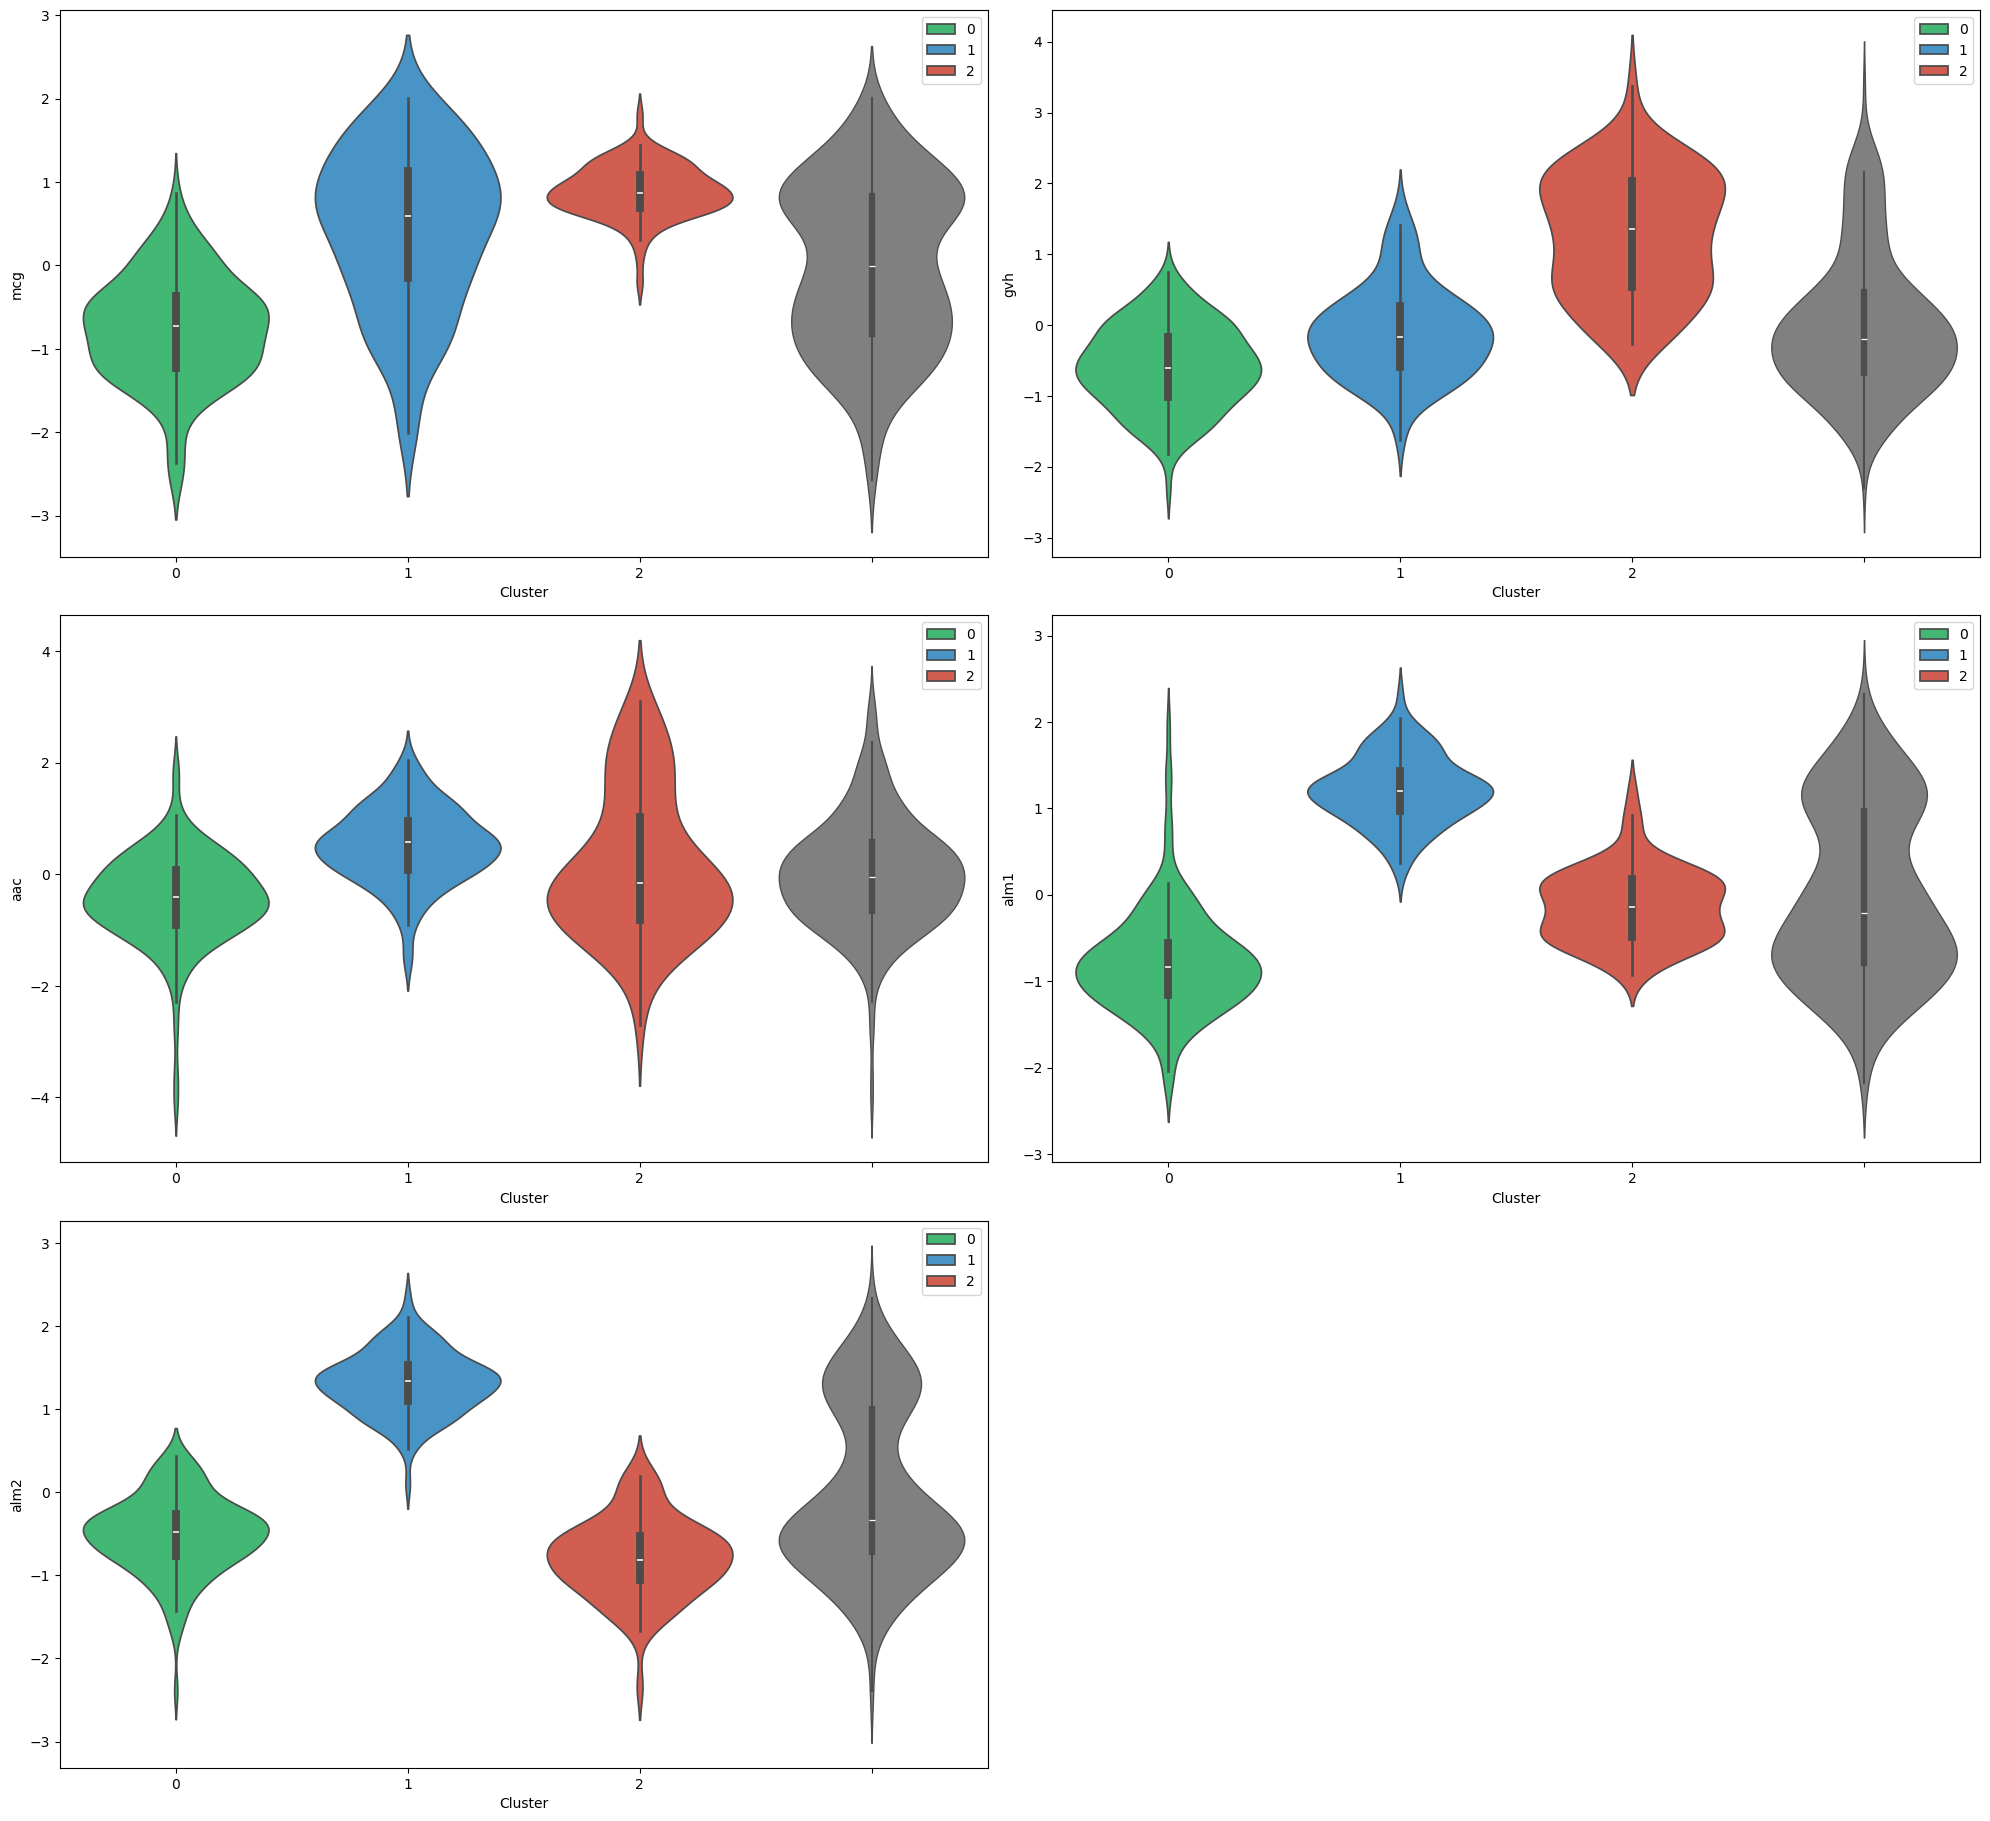

In [59]:
cluster_colors = ['#2ecc71', '#3498db', '#e74c3c']  # green, blue, red

plt.figure(figsize=(20, 30)) #violin plots for each attribute

plt.subplot(5,2,1)
sns.violinplot(x=cleaned_features['Cluster'], y=cleaned_features['mcg'], palette=cluster_colors, hue=cleaned_features['Cluster'])
sns.violinplot(y=cleaned_features['mcg'], color='gray', linewidth=1.0)

plt.subplot(5,2,2)
sns.violinplot(x=cleaned_features['Cluster'], y=cleaned_features['gvh'], palette=cluster_colors, hue=cleaned_features['Cluster'])
sns.violinplot(y=cleaned_features['gvh'], color='gray', linewidth=1.0)

plt.subplot(5,2,3)
sns.violinplot(x=cleaned_features['Cluster'], y=cleaned_features['aac'], palette=cluster_colors, hue=cleaned_features['Cluster'])
sns.violinplot(y=cleaned_features['aac'], color='gray', linewidth=1.0)

plt.subplot(5,2,4)
sns.violinplot(x=cleaned_features['Cluster'], y=cleaned_features['alm1'], palette=cluster_colors, hue=cleaned_features['Cluster'])
sns.violinplot(y=cleaned_features['alm1'], color='gray', linewidth=1.0)

plt.subplot(5,2,5)
sns.violinplot(x=cleaned_features['Cluster'], y=cleaned_features['alm2'], palette=cluster_colors, hue=cleaned_features['Cluster'])
sns.violinplot(y=cleaned_features['alm2'], color='gray', linewidth=1.0) 

plt.tight_layout()
plt.show()


## Observations from Violin Plots

- Cluster 0 (Green): Shows moderate values across most features, with relatively tight distributions. Notable for having the lowest mcg values and moderate-to-low alm1 and alm2 values.

- Cluster 1 (Blue): Characterized by high alm1 and alm2 values, with wider distributions indicating more variability. Shows moderate-to-high values for mcg, gvh, and aac.

- Cluster 2 (Red): Distinguished by high mcg values and moderate-to-high gvh values. Shows relatively compact distributions for aac, alm1, and alm2 features.
 
The violin plots reveal clear separation between clusters, particularly in the mcg, alm1, and alm2 features, suggesting these are important discriminating characteristics.


## Cluster Interpretation
The three clusters appear to represent different cellular localization patterns in Ecoli proteins: Cluster 0 (Green) contains mostly cytoplasmic proteins with low signal sequences, Cluster 1 (Blue) represents membrane proteins with high membrane-spanning scores, and Cluster 2 (Red) likely contains proteins with strong signal sequences for secretion or membrane targeting.


## Final Cluster Visualization

/var/folders/v0/_l0_v32n1f54t6h877vsg9wr0000gn/T/ipykernel_18619/3247617748.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette=cluster_colors)


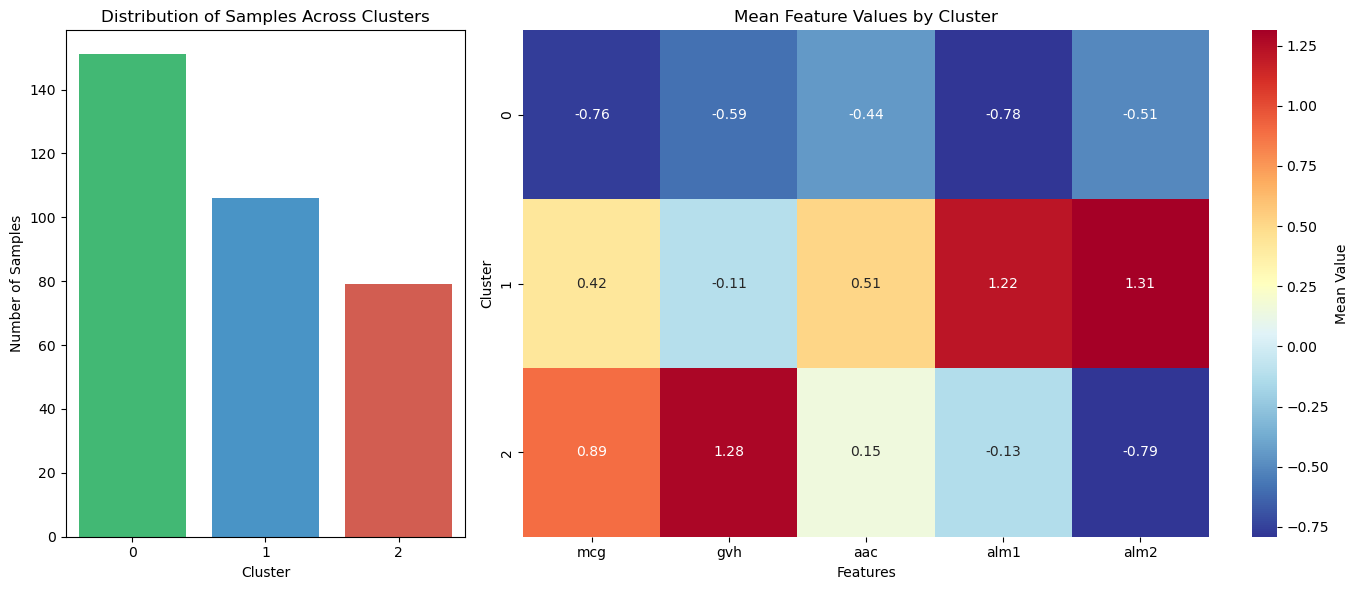

In [60]:
plt.figure(figsize=(14, 6)) #cluster size distribution and feature means


plt.subplot(1, 3, 1)
cluster_sizes = cleaned_features['Cluster'].value_counts()
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette=cluster_colors)
plt.title('Distribution of Samples Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Samples')


plt.subplot(1, 3, (2,3))
cluster_means = cleaned_features.groupby('Cluster')[['mcg', 'gvh', 'aac', 'alm1', 'alm2']].mean() #mean feature values for each cluster


sns.heatmap(cluster_means, cmap='RdYlBu_r', annot=True, fmt='.2f', #heatmap of cluster means
            cbar_kws={'label': 'Mean Value'})
plt.title('Mean Feature Values by Cluster')
plt.xlabel('Features')
plt.ylabel('Cluster')

plt.tight_layout()
plt.show()



## Classification Problem Using Logistic Regression


/opt/anaconda3/envs/project_cnt/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


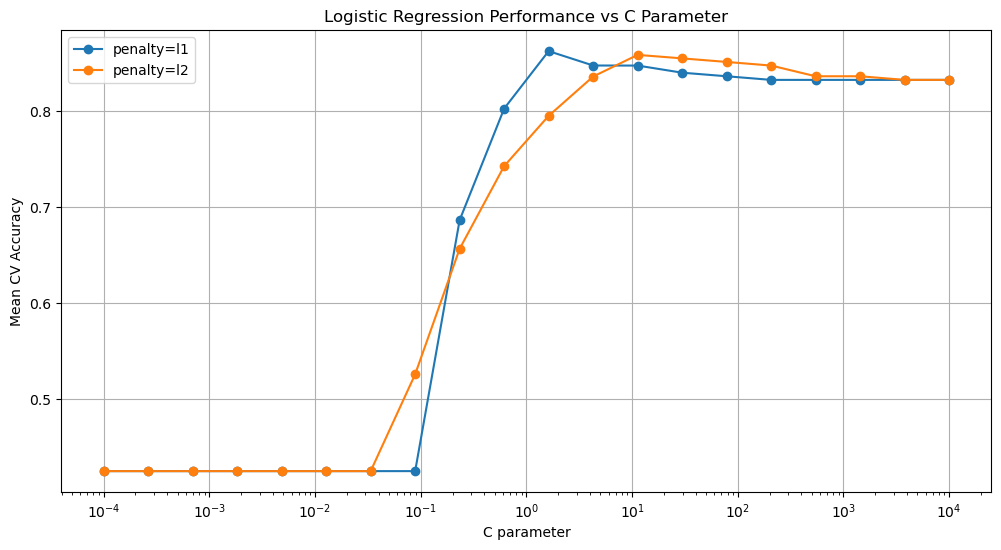

Best parameters: {'C': 1.623776739188721, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation accuracy: 0.862

Test set accuracy: 0.897

Classification Report:
              precision    recall  f1-score   support

          cp       0.94      1.00      0.97        29
          im       0.92      0.75      0.83        16
         imU       0.60      0.86      0.71         7
          om       1.00      1.00      1.00         4
         omL       1.00      1.00      1.00         1
          pp       1.00      0.82      0.90        11

    accuracy                           0.90        68
   macro avg       0.91      0.90      0.90        68
weighted avg       0.91      0.90      0.90        68



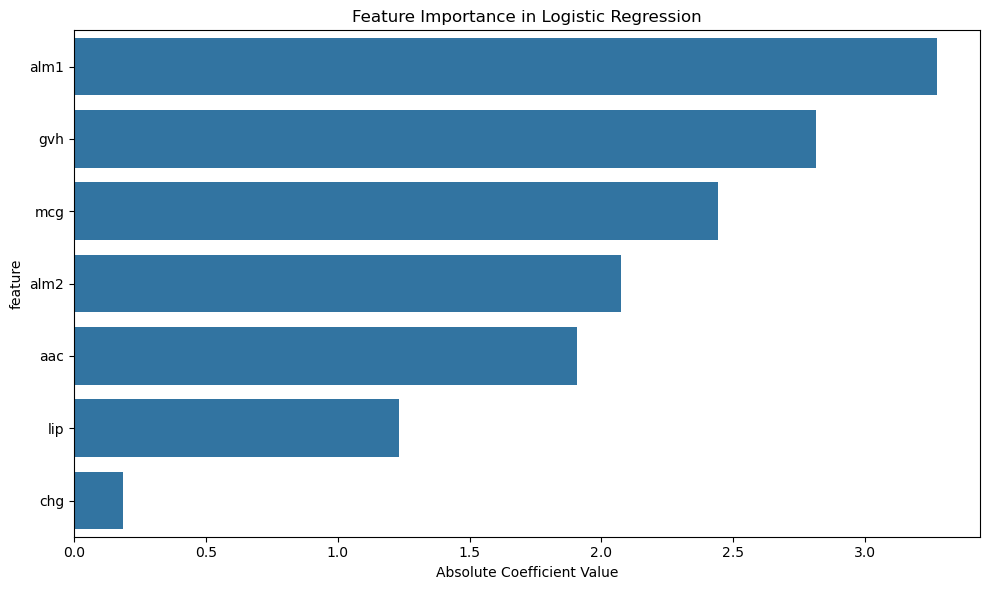

In [61]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


X = data.iloc[:, 1:-1]  # all features except sequence name and class
y = data.iloc[:, -1]    # class labels

scaler = MinMaxScaler() #scaling features
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) #stratified split to create training and testing sets
for train_index, test_index in sss.split(X_scaled, y):
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

param_grid = { #parameter grid for gridsearchcv
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [1000]
}

grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_) #results dataframe


plt.figure(figsize=(12, 6)) #visualization of C parameter vs mean test score for both penalties
for penalty in ['l1', 'l2']:
    mask = results['param_penalty'] == penalty
    plt.semilogx(
        results.loc[mask, 'param_C'], 
        results.loc[mask, 'mean_test_score'], 
        label=f'penalty={penalty}',
        marker='o'
    )

plt.xlabel('C parameter')
plt.ylabel('Mean CV Accuracy')
plt.title('Logistic Regression Performance vs C Parameter')
plt.legend()
plt.grid(True)
plt.show()

print("Best parameters:", grid_search.best_params_) #best parameters
print("Best cross-validation accuracy: {:.3f}".format(grid_search.best_score_)) #best cross-validation accuracy

best_model = grid_search.best_estimator_ #best model
y_pred = best_model.predict(X_test) #predictions on test set

print("\nTest set accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("\nClassification Report:")
print(classification_report(y_test, y_pred)) #classification report

importances = np.abs(best_model.coef_).mean(axis=0) #feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()